# Import all necessary python packages

In [96]:
# Howard Wang 05/14/19
# CSE 145: Embedded systems and design

# Main Database: https://surf.smartfin.org/

# Analyzing data from Buoy Calibration experiment to get wave direction.
# First, parse the data from the .CSV file containing ocean and wave motion data.
# This data comes from a controlled experiment (CE3), so we are assuming that 
# all of the vertical accelerations are contained in IMUA2.

# MATPLOTLIB
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

#from mpl_toolkits.basemap import Basemap

# DATAFRAMES
import pandas as pd
import numpy as np

# SCIPY
from scipy import stats
from scipy import constants
from scipy import signal #added
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from scipy.integrate import simps
from scipy.integrate import cumtrapz
import pylab as pylab

# SYSTEM and CONVERSION TOOLS
import math
import abc
import sys
import csv
import io
import os
import datetime
import pytz
import re
import statistics

# MODELING AND GRAPHS
import peakutils
import statsmodels.api as sm

# URL REQUESTS
import requests

# VECTORS AND GRAPHICS
import mpld3
import folium
# import cmocean
import skinematics as skin
from skinematics import quat, vector, misc, rotmat, imus, view
import pygame

# PLOTTING TOOLS
from plotly import tools 
import plotly.offline
import plotly.graph_objs as go

%matplotlib notebook
%matplotlib inline

print("Done!")

Done!


## Read from CSV
#Full csv:
#scripps_final_combined = pd.read_csv('Scripps_Final_Combined.csv')
#print(scripps_final_combined.head())

#Gets following columns: UTC, Time, IMU A1, IMU A2, IMU A3, IMU G1, IMU G2, IMU G3, IMU M1, IMU M2, Date
motion_df = pd.read_csv('Scripps_Final_Combined.csv', usecols = [i for i in range(2, 1)])
#motion_df = motion_df.drop(['Time'], axis=1)
print(motion_df.head())
print(len(motion_df))

In [41]:
## Read from CSV
#Full csv:
#scripps_final_combined = pd.read_csv('Scripps_Final_Combined.csv')
#print(scripps_final_combined.head())

#Gets following columns: UTC, Time, IMU A1, IMU A2, IMU A3, IMU G1, IMU G2, IMU G3, IMU M1, IMU M2, Date
motion_df = pd.read_csv('Scripps_Final_Combined.csv')
#motion_df = motion_df.drop(['Time'], axis=1)
print(motion_df.head())
print(len(motion_df))

   Unnamed: 0                                                 ID  \
0           0  google_106807627751629413403_0006667E228C_1709...   
1           1  google_106807627751629413403_0006667E228C_1709...   
2           2  google_106807627751629413403_0006667E228C_1709...   
3           3  google_106807627751629413403_0006667E228C_1709...   
4           4  google_106807627751629413403_0006667E228C_1709...   

                              UTC   Time    IMU A1     IMU A2    IMU A3  \
0  2017-09-09T18:02:11.2810+00:00  18:02  0.000000  11.070788  0.134075   
1  2017-09-09T18:02:11.4800+00:00  18:02 -0.325611  11.185710 -0.459687   
2  2017-09-09T18:02:11.7310+00:00  18:02  0.000000  10.419566  1.800440   
3  2017-09-09T18:02:11.9810+00:00  18:02  0.823605  10.860099 -0.114922   
4  2017-09-09T18:02:12.1800+00:00  18:02  0.670376  11.492168 -0.651223   

      IMU G1     IMU G2     IMU G3  IMU M1  IMU M2  IMU M3        Date  \
0  46.829268  15.853659  15.487805   -37.0  -199.0   517.0  2017-0

# Target a specific ride (14888)

# Scrape motion and ocean csv data from smartfin database

# Print out both dataframes

## Make copy of motion data

In [42]:
#print(motion_df)

saved_copy_motion_df = motion_df.copy(deep=True) #make a copy of the dataframe with raw data

print(saved_copy_motion_df)

         Unnamed: 0                                                 ID  \
0                 0  google_106807627751629413403_0006667E228C_1709...   
1                 1  google_106807627751629413403_0006667E228C_1709...   
2                 2  google_106807627751629413403_0006667E228C_1709...   
3                 3  google_106807627751629413403_0006667E228C_1709...   
4                 4  google_106807627751629413403_0006667E228C_1709...   
...             ...                                                ...   
1538163     2131900  google_113399247482189200727_000666D32248_1901...   
1538164     2131901  google_113399247482189200727_000666D32248_1901...   
1538165     2131902  google_113399247482189200727_000666D32248_1901...   
1538166     2131903  google_113399247482189200727_000666D32248_1901...   
1538167     2131904  google_113399247482189200727_000666D32248_1901...   

                                    UTC   Time    IMU A1     IMU A2    IMU A3  \
0        2017-09-09T18:02:11.2

# Drop NAs from dataset (excluding Lat and Long)

In [19]:
#Drop the "nan" values from the columns that we care about. 
#dropped_motion_df = motion_df
#print(dropped_motion_df)

In [43]:
#Reading data from Scripps_Final_Combined.csv
#The name of the motion dataframe is: motion_df

#Get times from the "Time" column to create time_o_list and time_e_list.
#Get imus from the "IMU A[*]" column to create the imu acc arrays. 

#Analyze following time period:
#September 9, 2017 -- 18:10 until 18:40

#Analyze particular UTC with actual heights (m) -- 30 minute sessions
# 2017-09-09T18:24:00.1810+00:00 to 2017-09-09T18:54:00.1810+00:00 -- 0.810768
# 2017-09-09T18:54:00.1810+00:00 to 2018-06-14T15:13:06.7140+00:00 -- 0.819912
# 2018-06-14T15:13:06.7140+00:00 to 2018-06-14T15:43:00.0050+00:00 -- 0.679704
# 2018-06-14T15:43:00.0050+00:00 to 2018-06-14T16:13:00.2150+00:00 -- 0.70104
# 2019-05-29T15:21:41.0170+00:00 to 2019-05-29T15:51:00.0140+00:00 -- 1.069848
# 2019-05-29T15:51:00.0140+00:00 to 2019-05-29T16:21:00.0620+00:00 -- 1.179576

START = '2018-06-14T15:13:06.7140+00:00'
END = '2018-06-14T15:43:00.0050+00:00'

time_e_array = []

time_array = motion_df[['Time']].to_numpy()
utc_time = motion_df[['UTC']].to_numpy()

start_index = np.where(utc_time==START)[0][0]
end_index = np.where(utc_time==END)[0][0]
length = end_index-start_index

mins_per_measure = 30/length
sec_per_measure = 60*mins_per_measure

print(sec_per_measure)

#start_time = 18*3600 + 10*60

for i in range(0, length):
    time_e_array.append(sec_per_measure*i)
deg = motion_df.loc[start_index:end_index-1,'Dp(deg)'].to_numpy()
#imu_array1 = motion_df.loc[start_index:end_index-1,'IMU A1'].to_numpy()
#imu_array2 = motion_df.loc[start_index:end_index-1,'IMU A2'].to_numpy()
#imu_array3 = motion_df.loc[start_index:end_index-1,'IMU A3'].to_numpy()
imu_array1 = motion_df.loc[start_index:end_index-1,'IMU M1'].to_numpy()
imu_array2 = motion_df.loc[start_index:end_index-1,'IMU M2'].to_numpy()
imu_array3 = motion_df.loc[start_index:end_index-1,'IMU M3'].to_numpy()

0.25094102885821834


In [44]:
# Function to parse time string and calculate half hour
def add_half_hour(time_str):
    # Parse string
    hrs = int(time_str[:2])
    mins = int(time_str[3:5])
    
    # Set minutes and hours
    if (mins < 30):
        mins += 30
    else:
        mins -= 30
        if (hrs == 23):
            hrs = 0
        else:
            hrs += 1
            
    # Check if mins and hrs are single digits
    if (mins < 10):
        mins = '0'+str(mins)
    if (hrs < 10):
        hrs = '0'+str(hrs)
        
    return str(hrs)+':'+str(mins)

# Parse int and compare functions in case we need them in the future

def parse_int(time_str):
    return 60*int(time_str[:2])+int(time_str[3:5])

def is_less_than_eq(str1, str2):
    if (str1[:2]=='23' and str2[:2]=='00'):
        return True
    
    str1 = parse_int(str1)
    str2 = parse_int(str2)
    
    return (str1 <= str2)

In [72]:
%%time

### Goal: create an array of arrays of IMU A2 data ###
surf_sessions = []
degree_labels = []
utc_labels = []
date_labels = []

## Step 1: get 5 columns of the data frame to iterate over - ID, Time, IMU A2, Date, Height ##
df_parser = motion_df[['ID', 'UTC', 'Time', 'IMU M1','IMU M2','IMU M3', 'Date', 'Dp(deg)']]

# Convert to numpy array
id_parser = df_parser[['ID']].to_numpy()
time_parser = df_parser[['Time']].to_numpy()
utc_parser = df_parser[['UTC']].to_numpy()
imuM1_parser = df_parser[['IMU M1']].to_numpy()
imuM2_parser = df_parser[['IMU M2']].to_numpy()
imuM3_parser = df_parser[['IMU M3']].to_numpy()
date_parser = df_parser[['Date']].to_numpy()
degree_parser = df_parser[['Dp(deg)']].to_numpy()

## Step 2: loop through every data point ##
working_array = []
working_m1 = []
working_m2 = []
working_m3 = []
skip_check = '00:00'
end_index_check = None

for start_index in range(0, len(id_parser)):
    ## Goal 1: Append IMU data if we are in the half-hour segment ##
    if (end_index_check != None):
        # Check if we've reached the end of the half hour before appending
        if (start_index==end_index_check):
            working_array.append(working_m1)
            working_array.append(working_m2)
            working_array.append(working_m3)
            surf_sessions.append(working_array)
            
            working_array = []
            working_m1 = []
            working_m2 = []
            working_m3 = []
            
            end_index_check = None
        else:
            working_m1.append(imuM1_parser[start_index][0])
            working_m2.append(imuM2_parser[start_index][0])
            working_m3.append(imuM3_parser[start_index][0])
        continue
        
    ## Goal 2: Check if degree of current and half-hour times are equal ##
    start = time_parser[start_index][0]
    
    # Skip through a minute if it has already been checked and invalidated
    if (start==skip_check):
        continue
        
    # Set end point
    end = add_half_hour(start)
    
    # Check if ride is still valid for half hour time
    try:
        # End index is where the time is equal to end and we are in the same ride as we started
        end_index = np.where((time_parser==end) & (id_parser==id_parser[start_index]))[0][0]
    except IndexError:
        # Skip through minutes
        skip_check = start
        continue
    else:
        # (occurs after try block) skip if the degrees don't match
        if (degree_parser[start_index]!=degree_parser[end_index-1]):
            skip_check = start
        else:
            # add to array if degrees do match
            working_m1.append(imuM1_parser[start_index][0])
            working_m2.append(imuM2_parser[start_index][0])
            working_m3.append(imuM3_parser[start_index][0])
            
            degree_labels.append(degree_parser[start_index][0])
            utc_labels.append(utc_parser[start_index][0])
            date_labels.append(date_parser[start_index][0])
            
            end_index_check = end_index
            skip_check = '00:00'
            
            print("Session: ", len(surf_sessions)+1, ", Date: ", date_parser[start_index][0])
            print("At ", start, " and ", end)
            print("Start: ", degree_parser[start_index], " and End: ", degree_parser[end_index-1], "\n")

print("Total sessions: ", len(surf_sessions))
print("Total degrees: ", len(degree_labels))

Session:  1 , Date:  2017-09-09
At  18:10  and  18:40
Start:  [287.]  and End:  [287.] 

Session:  2 , Date:  2017-09-09
At  18:40  and  19:10
Start:  [282.]  and End:  [282.] 

Session:  3 , Date:  2018-06-14
At  15:20  and  15:50
Start:  [286.]  and End:  [286.] 

Session:  4 , Date:  2018-06-14
At  15:50  and  16:20
Start:  [283.]  and End:  [283.] 

Session:  5 , Date:  2019-05-29
At  15:50  and  16:20
Start:  [289.]  and End:  [289.] 

Session:  6 , Date:  2019-05-29
At  16:20  and  16:50
Start:  [287.]  and End:  [287.] 

Session:  7 , Date:  2018-08-12
At  14:46  and  15:16
Start:  [257.]  and End:  [257.] 

Session:  8 , Date:  2018-08-12
At  15:20  and  15:50
Start:  [255.]  and End:  [255.] 

Session:  9 , Date:  2017-08-08
At  16:40  and  17:10
Start:  [284.]  and End:  [284.] 

Session:  10 , Date:  2017-08-08
At  17:10  and  17:40
Start:  [289.]  and End:  [289.] 

Session:  11 , Date:  2017-08-08
At  17:40  and  18:10
Start:  [289.]  and End:  [289.] 

Session:  12 , Date

Session:  93 , Date:  2018-06-05
At  16:20  and  16:50
Start:  [290.]  and End:  [290.] 

Session:  94 , Date:  2017-09-07
At  18:40  and  19:10
Start:  [278.]  and End:  [278.] 

Session:  95 , Date:  2017-09-07
At  19:10  and  19:40
Start:  [281.]  and End:  [281.] 

Session:  96 , Date:  2017-09-07
At  19:40  and  20:10
Start:  [284.]  and End:  [284.] 

Session:  97 , Date:  2017-06-30
At  01:40  and  02:10
Start:  [284.]  and End:  [284.] 

Session:  98 , Date:  2017-06-30
At  02:10  and  02:40
Start:  [284.]  and End:  [284.] 

Session:  99 , Date:  2017-09-08
At  23:20  and  23:50
Start:  [282.]  and End:  [282.] 

Session:  100 , Date:  2017-09-09
At  00:10  and  00:40
Start:  [280.]  and End:  [280.] 

Session:  101 , Date:  2017-08-02
At  17:10  and  17:40
Start:  [280.]  and End:  [280.] 

Session:  102 , Date:  2017-08-02
At  17:40  and  18:10
Start:  [284.]  and End:  [284.] 

Session:  103 , Date:  2017-06-24
At  21:40  and  22:10
Start:  [275.]  and End:  [275.] 

Sessio

In [61]:
#Drop the "nan" values from the columns that we care about. 
dropped_motion_df = motion_df.dropna(subset=['Time', 'IMU A1', 'IMU A2', 'IMU A3', 'IMU G1', 'IMU G2', 'IMU G3', 'IMU M1', 
                                            'IMU M2', 'IMU M3','Dp(deg)'])
print(dropped_motion_df)

         Unnamed: 0                                                 ID  \
0                 0  google_106807627751629413403_0006667E228C_1709...   
1                 1  google_106807627751629413403_0006667E228C_1709...   
2                 2  google_106807627751629413403_0006667E228C_1709...   
3                 3  google_106807627751629413403_0006667E228C_1709...   
4                 4  google_106807627751629413403_0006667E228C_1709...   
...             ...                                                ...   
1538163     2131900  google_113399247482189200727_000666D32248_1901...   
1538164     2131901  google_113399247482189200727_000666D32248_1901...   
1538165     2131902  google_113399247482189200727_000666D32248_1901...   
1538166     2131903  google_113399247482189200727_000666D32248_1901...   
1538167     2131904  google_113399247482189200727_000666D32248_1901...   

                                    UTC   Time    IMU A1     IMU A2    IMU A3  \
0        2017-09-09T18:02:11.2

# Calculate time offsets, and normalize columns

# Convert raw units to actual units (acc to [m/s^2]) and (time to [s])

In [62]:
#Raw acceleration constant 512 = 1g (accelerometer's measured force due to gravity)
g_const = 512

#Approximate measurement for gravity:
gravity = 9.80665

# Correct the IMU Acceleration columns into units of meters
def convert_acc_units(acc_array):
    ret_array = []
    for a in acc_array:
        #Acceleration is now in m/s^2, need to subtract gravity from vertical axis. (??)
        new_a = a / g_const * gravity + gravity
        ret_array.append(new_a)
    return ret_array

imu1_array = convert_acc_units(imu_array1) #new units in m/s^2
imu2_array = convert_acc_units(imu_array2) #new units in m/s^2
imu3_array = convert_acc_units(imu_array3) #new units in m/s^2


# To check:
#for x,y in zip(imu2_array, imu_array_A2):
#   print(x,y)
print(len(time_e_array))

# To check:
for t in time_e_array:
    print(t)
print("Done!")

7173
0.0
0.25094102885821834
0.5018820577164367
0.752823086574655
1.0037641154328734
1.2547051442910917
1.50564617314931
1.7565872020075284
2.0075282308657467
2.258469259723965
2.5094102885821834
2.760351317440402
3.01129234629862
3.262233375156838
3.5131744040150568
3.7641154328732753
4.015056461731493
4.265997490589712
4.51693851944793
4.767879548306149
5.018820577164367
5.269761606022585
5.520702634880804
5.771643663739022
6.02258469259724
6.273525721455458
6.524466750313676
6.775407779171895
7.0263488080301135
7.277289836888332
7.528230865746551
7.779171894604769
8.030112923462987
8.281053952321205
8.531994981179423
8.782936010037641
9.03387703889586
9.28481806775408
9.535759096612297
9.786700125470515
10.037641154328734
10.288582183186952
10.53952321204517
10.790464240903388
11.041405269761608
11.292346298619826
11.543287327478044
11.794228356336262
12.04516938519448
12.296110414052698
12.547051442910917
12.797992471769135
13.048933500627353
13.299874529485573
13.55081555834379
13

499.12170639899625
499.3726474278545
499.6235884567127
499.8745294855709
500.12547051442914
500.37641154328736
500.6273525721456
500.8782936010038
501.129234629862
501.38017565872025
501.63111668757847
501.8820577164367
502.1329987452949
502.38393977415313
502.63488080301136
502.8858218318696
503.1367628607278
503.38770388958596
503.6386449184442
503.8895859473024
504.14052697616063
504.39146800501885
504.6424090338771
504.8933500627353
505.1442910915935
505.39523212045174
505.64617314930996
505.8971141781682
506.1480552070264
506.3989962358846
506.64993726474285
506.90087829360107
507.1518193224593
507.4027603513175
507.6537013801757
507.9046424090339
508.1555834378921
508.40652446675034
508.65746549560856
508.9084065244668
509.159347553325
509.4102885821832
509.66122961104145
509.91217063989967
510.1631116687579
510.4140526976161
510.66499372647434
510.91593475533256
511.1668757841908
511.417816813049
511.6687578419072
511.9196988707654
512.1706398996237
512.4215809284818
512.6725219

875.2823086574656
875.5332496863238
875.784190715182
876.0351317440402
876.2860727728985
876.5370138017566
876.7879548306149
877.0388958594731
877.2898368883314
877.5407779171895
877.7917189460478
878.042659974906
878.2936010037641
878.5445420326224
878.7954830614806
879.0464240903389
879.297365119197
879.5483061480553
879.7992471769135
880.0501882057717
880.3011292346299
880.5520702634882
880.8030112923464
881.0539523212046
881.3048933500628
881.5558343789211
881.8067754077792
882.0577164366375
882.3086574654957
882.5595984943538
882.8105395232121
883.0614805520703
883.3124215809286
883.5633626097867
883.814303638645
884.0652446675032
884.3161856963615
884.5671267252196
884.8180677540779
885.0690087829361
885.3199498117943
885.5708908406525
885.8218318695108
886.072772898369
886.3237139272272
886.5746549560854
886.8255959849436
887.0765370138018
887.32747804266
887.5784190715183
887.8293601003764
888.0803011292347
888.3312421580929
888.5821831869512
888.8331242158093
889.0840652446676

1251.693851944793
1251.9447929736514
1252.1957340025094
1252.4466750313677
1252.697616060226
1252.9485570890843
1253.1994981179423
1253.4504391468006
1253.7013801756589
1253.9523212045171
1254.2032622333752
1254.4542032622335
1254.7051442910918
1254.9560853199498
1255.207026348808
1255.4579673776664
1255.7089084065246
1255.9598494353827
1256.210790464241
1256.4617314930993
1256.7126725219575
1256.9636135508156
1257.2145545796739
1257.4654956085321
1257.7164366373904
1257.9673776662485
1258.2183186951067
1258.469259723965
1258.7202007528233
1258.9711417816814
1259.2220828105396
1259.473023839398
1259.723964868256
1259.9749058971142
1260.2258469259725
1260.4767879548308
1260.7277289836888
1260.9786700125471
1261.2296110414054
1261.4805520702637
1261.7314930991217
1261.98243412798
1262.2333751568383
1262.4843161856966
1262.7352572145546
1262.986198243413
1263.2371392722712
1263.4880803011292
1263.7390213299875
1263.9899623588458
1264.240903387704
1264.4918444165621
1264.7427854454204
1264

1627.8544542032623
1628.1053952321206
1628.3563362609789
1628.607277289837
1628.8582183186952
1629.1091593475535
1629.3601003764118
1629.6110414052698
1629.861982434128
1630.1129234629864
1630.3638644918447
1630.6148055207027
1630.865746549561
1631.1166875784193
1631.3676286072775
1631.6185696361356
1631.8695106649939
1632.1204516938521
1632.3713927227102
1632.6223337515685
1632.8732747804268
1633.124215809285
1633.375156838143
1633.6260978670014
1633.8770388958596
1634.127979924718
1634.378920953576
1634.6298619824342
1634.8808030112925
1635.1317440401508
1635.3826850690089
1635.6336260978671
1635.8845671267254
1636.1355081555835
1636.3864491844417
1636.6373902133
1636.8883312421583
1637.1392722710164
1637.3902132998746
1637.641154328733
1637.8920953575912
1638.1430363864492
1638.3939774153075
1638.6449184441658
1638.895859473024
1639.1468005018821
1639.3977415307404
1639.6486825595987
1639.899623588457
1640.150564617315
1640.4015056461733
1640.6524466750316
1640.9033877038896
1641.15

# Calculate and plot magnitude of acceleration on X-Z plane

Graph of XZ Acceleration vs. Time


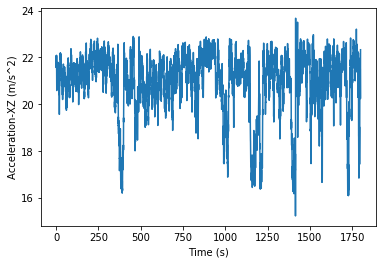

In [63]:
# Square x and z acceleration values
accel_xz_array = [];
for i in range(0, len(imu1_array)): 
    currMagnitude = math.sqrt((math.pow(imu1_array[i], 2) + math.pow(imu3_array[i], 2)))
    accel_xz_array.append(currMagnitude)

print("Graph of XZ Acceleration vs. Time")

plt.plot(time_e_array, accel_xz_array)
plt.xlabel("Time (s)")
plt.ylabel("Acceleration-XZ (m/s^2)")
plt.show()

# Center and Calibrate Magnetometer Data

In [78]:
# Offset variables help in recentering the magnetic data in order to define direction and use trig functions
M1_offset_var = 219.786
M2_offset_var = 180
M3_offset_var = 280

def calibrate_magn_data(magn_array, offset_value):
    ret_array = []
    for m in magn_array:
        new_m = m - offset_value
        ret_array.append(new_m)
    return ret_array

#imuM1_array = calibrate_magn_data(imu_array1, M1_offset_var)
#imuM2_array = calibrate_magn_data(imu_array2, M2_offset_var)
#imuM3_array = calibrate_magn_data(imu_array3, M3_offset_var)


#imuM1_array = calibrate_magn_data(imuM1_parser, M1_offset_var)
#imuM2_array = calibrate_magn_data(imuM2_parser, M1_offset_var)
#imuM3_array = calibrate_magn_data(imuM3_parser, M1_offset_var)

# Check 
# print(imuM1_array)
print("Done.")

129
Done.


# Loop through entire dataset

In [108]:
def azimuth(x,y,z):
    real_y = y * (-1) # This is to account for y 
    return (180/math.pi * math.atan2(real_y,x)) % 360

def altitude(x,y,z):
    h = math.hypot(y, x)
    return 180/math.pi * math.atan2(z,h)

def printAltAzi(alt, azi):
    print ("Alt:", alt, "\n", "Azi:",azi,"\n")

err_list = []
exp_degree_list = []

for index in range(0, len(surf_sessions)):
    imu_surf_M1 = surf_sessions[index][0]
    imu_surf_M2 = surf_sessions[index][1]
    imu_surf_M3 = surf_sessions[index][2]
    
    imuM1_array = calibrate_magn_data(imu_surf_M1, M1_offset_var)
    imuM2_array = calibrate_magn_data(imu_surf_M2, M2_offset_var)
    imuM3_array = calibrate_magn_data(imu_surf_M3, M3_offset_var)
    
    magn_height = len(imuM1_array)
    magn_array = np.zeros(shape=(magn_height,3))
    
    print("\nFor Magnetometer: ")
    for x in range(len(magn_array)):
        magn_array[x,0] = imuM1_array[x]
        magn_array[x,1] = imuM2_array[x]
        magn_array[x,2] = imuM3_array[x]
    
    board_magn = magn_array.copy()
    temp_x_magn = board_magn[:,0] * (-1)
    temp_y_magn = board_magn[:,1] * (-1)
    temp_z_magn = board_magn[:,2] * (-1)
    board_magn[:,0] = temp_x_magn
    board_magn[:,1] = temp_y_magn
    board_magn[:,2] = temp_z_magn
    
    heading_azimuth = board_magn[:,0].copy()
    #heading_altitude = board_magn[:,0].copy()

    i = 0     #iterator
    #for i in range(len(M1_no_out)):
    while i < len(heading_azimuth):
        heading_azimuth[i] = azimuth(board_magn[i,0], board_magn[i,1], board_magn[i,2])
        
        #heading_altitude[i] = altitude(board_magn[i,0], board_magn[i,1], board_magn[i,2])
        #printAltAzi(heading_altitude[i],heading_azimuth[i])
        
        i += 1

        '''
    heading_azi_plot = plt.figure(figsize=(10,5))
    azi_plot = heading_azi_plot.add_subplot(111)
    azi_plot.plot(time_e_array, heading_azimuth)
    azi_plot.set_title("Azimuth vs. Time")
    azi_plot.set_xlabel("Time Elapsed[sec]")
    azi_plot.set_ylabel("Azimuth [deg]")
    azi_plot.set_ylim([-50,400])
    '''
    
    exp_degree = sum(heading_azimuth/len(heading_azimuth)) 
    actual = sum(deg/ len(deg))
    err = 100*abs(actual-exp_degree)/actual
    print("Session: ", index+1)
    print("error: ", err)
    err_list.append(err)
    exp_degree_list.append(exp_degree)

    '''heading_alt_plot = plt.figure(figsize=(10,5))
    alt_plot = heading_alt_plot.add_subplot(111)
    alt_plot.plot(time_e_array, heading_altitude)
    alt_plot.set_title("Altitude vs. Time")
    alt_plot.set_xlabel("Time Elapsed [sec]")
    alt_plot.set_ylabel("Altitude [deg]")
    plt.show()
    '''
    
print(len(err_list))
print("Average error: ", statistics.mean(err_list))
print("Median error: ", statistics.median(err_list))


For Magnetometer: 
Session:  1
error:  6.174124718090793

For Magnetometer: 
Session:  2
error:  4.938634107923763

For Magnetometer: 
Session:  3
error:  10.891707950225356

For Magnetometer: 
Session:  4
error:  0.17517783881166993

For Magnetometer: 
Session:  5
error:  6.305142781962362

For Magnetometer: 
Session:  6
error:  5.3081198078311465

For Magnetometer: 
Session:  7
error:  1.4224369249570183

For Magnetometer: 
Session:  8
error:  0.642289212050666

For Magnetometer: 
Session:  9
error:  3.888651255962771

For Magnetometer: 
Session:  10
error:  92.52147770773666

For Magnetometer: 
Session:  11
error:  93.12551235842642

For Magnetometer: 
Session:  12
error:  2.9979808298240154

For Magnetometer: 
Session:  13
error:  2.5061743255112683

For Magnetometer: 
Session:  14
error:  1.8905783207794977

For Magnetometer: 
Session:  15
error:  8.170030859598453

For Magnetometer: 
Session:  16
error:  6.843389418323666

For Magnetometer: 
Session:  17
error:  3.39528358357799

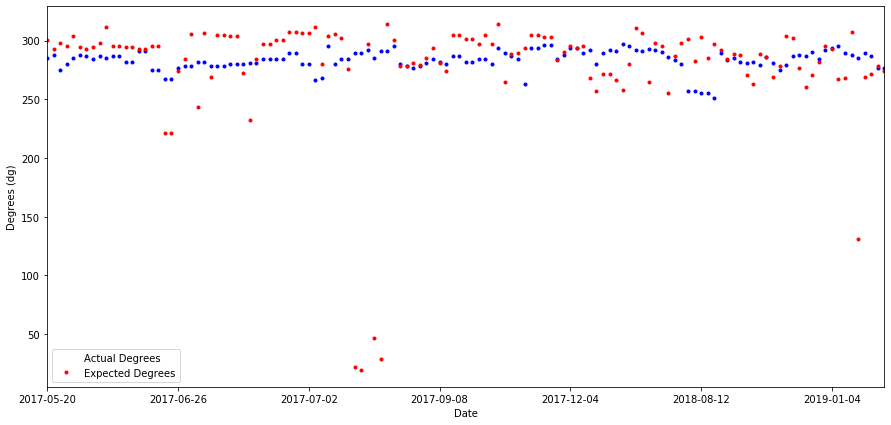

In [109]:
# x-axis will be dates of surf sessions, sorted
# y-axis will be their corresponding actual degrees and expected degree values

# Build dataframe and sort by UTC time
data_to_plot = list(zip(utc_labels, date_labels, degree_labels, exp_degree_list))
plot_df = pd.DataFrame(data_to_plot, columns=['UTC', 'Date', 'Actual Degrees', 'Expected Degrees'])
plot_df.sort_values('UTC', inplace=True)

ax = plt.gca()
plot_df.plot(x='Date', y='Actual Degrees', color='blue', ax=ax, style='.', figsize=(15,7))
plot_df.plot(x='Date', y='Expected Degrees', color='red', ax=ax, style='.')
plt.xlabel('Date')
plt.ylabel('Degrees (dg)')
plt.show()


# Set up 3xN arrays for Magnetometer and Accel values 

In [95]:
# Create N x 3 arrays for functions that need them later on, such as Scikit Kinematics
magn_height = len(imuM1_array)
acc_height = len(imu1_array)

acc_array = np.zeros(shape=(acc_height,3))
magn_array = np.zeros(shape=(magn_height,3))

print("For Accelerometer: ")
for x in range(len(acc_array)):
    acc_array[x,0] = imu1_array[x]
    acc_array[x,1] = imu2_array[x]
    acc_array[x,2] = imu3_array[x]
print(acc_array)

print("\nFor Magnetometer: ")
for x in range(len(magn_array)):
    magn_array[x,0] = imuM1_array[x]
    magn_array[x,1] = imuM2_array[x]
    magn_array[x,2] = imuM3_array[x]

print(magn_array)
print("Done.")

For Accelerometer: 
[[16.146496    8.44674346 14.61420693]
 [16.0124207   8.5042043  14.48013164]
 [16.12734238  8.61912598 14.48013164]
 ...
 [13.92467686  7.83382783 14.69082139]
 [14.34605635  7.98705674 15.80173096]
 [14.84405029  8.44674346 16.68279717]]

For Magnetometer: 
[[ 111.214 -251.     -29.   ]
 [ 104.214 -248.     -36.   ]
 [ 110.214 -242.     -36.   ]
 ...
 [  -4.786 -283.     -25.   ]
 [  17.214 -275.      33.   ]
 [  43.214 -251.      79.   ]]
Done.


# Conversion from fin-frame to board-frame

Orientation from here onwards will be from the board/surfers reference frame (yaw left = turning left)

x = -IMU1, y = -IMU3, z = -IMU2

In [66]:
# The new array for board reference frame will have the IMUs in columns according to X,Y,Z directions
board_acc = acc_array.copy()       # Reassign to the correct axes as stated above
temp_x_acc = board_acc[:,0] * (-1)
temp_y_acc = board_acc[:,1] * (-1)
temp_z_acc = board_acc[:,2] * (-1)
board_acc[:,0] = temp_x_acc     # X acceleration
board_acc[:,1] = temp_y_acc     # Y acceleration
board_acc[:,2] = temp_z_acc     # Z acceleration
print(board_acc)
print("\n")

board_magn = magn_array.copy()
temp_x_magn = board_magn[:,0] * (-1)
temp_y_magn = board_magn[:,1] * (-1)
temp_z_magn = board_magn[:,2] * (-1)
board_magn[:,0] = temp_x_magn
board_magn[:,1] = temp_y_magn
board_magn[:,2] = temp_z_magn
print(board_magn)
print("Done.")

[[-16.146496    -8.44674346 -14.61420693]
 [-16.0124207   -8.5042043  -14.48013164]
 [-16.12734238  -8.61912598 -14.48013164]
 ...
 [-13.92467686  -7.83382783 -14.69082139]
 [-14.34605635  -7.98705674 -15.80173096]
 [-14.84405029  -8.44674346 -16.68279717]]


[[-111.214  251.      29.   ]
 [-104.214  248.      36.   ]
 [-110.214  242.      36.   ]
 ...
 [   4.786  283.      25.   ]
 [ -17.214  275.     -33.   ]
 [ -43.214  251.     -79.   ]]
Done.


# Calculate magnitude of XYZ acceleration vs time

7173
Graph of XYZ Acceleration vs. Time


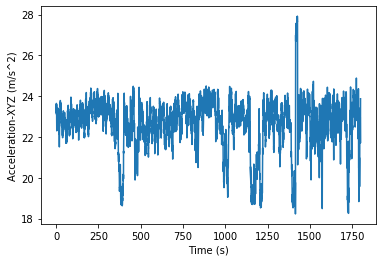

In [67]:
# Square x, y and z acceleration values
accel_xyz_array = [];
for i in range(0, len(board_acc)): 
    currMagnitude = math.sqrt(math.pow(board_acc[i][0], 2) + math.pow(board_acc[i][1], 2) + math.pow(board_acc[i][2], 2))
    accel_xyz_array.append(currMagnitude)

# Check length
print(len(accel_xyz_array))
print("Graph of XYZ Acceleration vs. Time")

plt.plot(time_e_array, accel_xyz_array)
plt.xlabel("Time (s)")
plt.ylabel("Acceleration-XYZ (m/s^2)")
plt.show()

# Azimuth and altitude calculations

Starting full data set analysis:
[[-111.214  251.      29.   ]
 [-104.214  248.      36.   ]
 [-110.214  242.      36.   ]
 ...
 [   4.786  283.      25.   ]
 [ -17.214  275.     -33.   ]
 [ -43.214  251.     -79.   ]]
Done.
286.9251359263996
258.8375933140107
0.10851415458153449


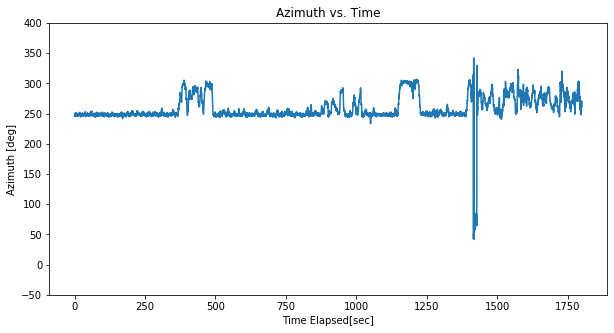

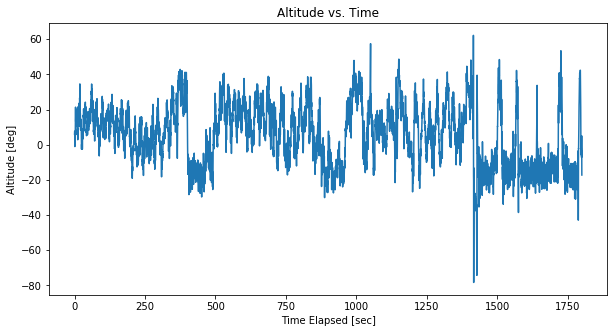

In [80]:
# Azimuth and Altitude LEGEND:
# Altitude is the angle between the ground and the vector 
# Azimuth is the angle going clockwise from 0 deg North:
# N - 0/360deg, E - 90deg, S - 180deg, W - 270deg

# This will get complicated (ie make cases or lots of if statements) when rotations about the heading become more prevalent
def azimuth(x,y,z):
    real_y = y * (-1) # This is to account for y 
    return (180/math.pi * math.atan2(real_y,x)) % 360

def altitude(x,y,z):
    h = math.hypot(y, x)
    return 180/math.pi * math.atan2(z,h)

def printAltAzi(alt, azi):
    print ("Alt:", alt, "\n", "Azi:",azi,"\n")
# These values are uncorrected values: still need to add or subtract 'declination'
#     (for AziMuth) and 'inclination' (for Altitude) correction values for geographical location

print("Starting full data set analysis:")
avg_error_list = []
expected_heights = []

#for index in range(0, len(surf_sessions)):

#acc_array = surf_sessions[index]
    #dacc_test_array = signal.detrend(acc_array)
    
    # The new array for board reference frame will have the IMUs in columns according to X,Y,Z directions


board_magn = magn_array.copy()
temp_x_magn = board_magn[:,0] * (-1)
temp_y_magn = board_magn[:,1] * (-1)
temp_z_magn = board_magn[:,2] * (-1)
board_magn[:,0] = temp_x_magn
board_magn[:,1] = temp_y_magn
board_magn[:,2] = temp_z_magn
print(board_magn)
print("Done.")
    
heading_altitude = board_magn[:,0].copy()
heading_azimuth = board_magn[:,0].copy()

i = 0     #iterator
#for i in range(len(M1_no_out)):
while i < len(heading_altitude):
    heading_altitude[i] = altitude(board_magn[i,0], board_magn[i,1], board_magn[i,2])
    heading_azimuth[i] = azimuth(board_magn[i,0], board_magn[i,1], board_magn[i,2])
    #print(heading_azimuth[i])
    #printAltAzi(heading_altitude[i],heading_azimuth[i])
    i += 1

anss = sum(heading_azimuth/len(heading_azimuth)) 
actual = sum(deg/ len(deg))
print(actual)
print(anss)
print((actual-anss)/anss)  


heading_azi_plot = plt.figure(figsize=(10,5))
azi_plot = heading_azi_plot.add_subplot(111)
azi_plot.plot(time_e_array, heading_azimuth)
azi_plot.set_title("Azimuth vs. Time")
azi_plot.set_xlabel("Time Elapsed[sec]")
azi_plot.set_ylabel("Azimuth [deg]")
azi_plot.set_ylim([-50,400])

heading_alt_plot = plt.figure(figsize=(10,5))
alt_plot = heading_alt_plot.add_subplot(111)
alt_plot.plot(time_e_array, heading_altitude)
alt_plot.set_title("Altitude vs. Time")
alt_plot.set_xlabel("Time Elapsed [sec]")
alt_plot.set_ylabel("Altitude [deg]")
plt.show()

#for t in range(len(time_e_array)):
    #printAltAzi(heading_altitude[t], heading_azimuth[t])

# Plot polar azimuth and altitude

In [ ]:
# Note: acc_array = acc_list = imu2_array = imu_array2
# ALL CODE RELATED TO PLOTTING INDIVIDUAL GRAPHS HAS BEEN COMMENTED OUT

print("Starting full data set analysis:")
avg_error_list = []
expected_heights = []

for index in range(0, len(surf_sessions)):

    #acc_array = surf_sessions[index]
    dacc_test_array = signal.detrend(acc_array)

    butter_t_lfilter = butter_bandpass_lfilter(dacc_test_array, lowcut, highcut, fs, order=5)
    butter_t_filtfilt = butter_bandpass_filtfilt(dacc_test_array, lowcut, highcut, fs, order=5)

    ##For entire data:
    #Get as close to just the signal (don't want noise)    
    new_t_test, new_acc_test = calculate_new_range(time_array, acc_array, 0, 1800)
    new_t_test, new_dacc_test = calculate_new_range(time_array, dacc_test_array, 0, 1800)
    disp_butter_integral_t = double_integral_bandpass(new_t_test, new_acc_test, new_dacc_test, lowcut, highcut, fs, order)
    print("Done.")

    new_dacc = np.array(new_dacc_test)
    new_t = np.array(new_t_test)

    '''
    indices = peakutils.indexes(new_dacc, thres=0.02/max(new_dacc), min_dist=100)
    
    col_t = new_t
    col_a = new_dacc

    index_max = peakutils.indexes(col_a, thres=0.66, min_dist=25)
    index_min = peakutils.indexes(-col_a, thres=0.66, min_dist=25)

    f0 = plt.figure(figsize=(12,5))
    ax0 = f0.add_subplot(121)

    ax0.plot(col_t, col_a, lw=0.4, alpha=0.2, color="black" )
    ax0.plot(col_t[index_max], col_a[index_max], marker="o", ls="", ms=3, color="red" )
    ax0.plot(col_t[index_min], col_a[index_min], color ="orange", marker="o", ls="", ms=3 )
    ax0.set_title("Displacement vs. Time")
    ax0.set_xlabel("Time [s]")
    ax0.set_ylabel('Displacement [m]')
    '''

    # Use largest third method with medians
    n = int(len(new_dacc)/3)
    xn = new_dacc
    largest_third = (xn[np.argsort(xn)[-n:]])

    exp_wave_height = np.median(largest_third)
    expected_heights.append(exp_wave_height)
    # Note: arbitrarily dividing exp_wave_height by 1.1 yields a lower % error 
    
    actual = height_labels[index]
    err = percent_error(actual, exp_wave_height)
    avg_error_list.append(err)
    
    print("Significant wave height calculated as: ", exp_wave_height, " for session ", index+1)
    print("Actual wave height: ", actual)
    print("Percent error: ", err)
    
print("\nMean error: ", statistics.mean(avg_error_list))
print("Median error: ", statistics.median(avg_error_list))

In [ ]:
# Fixing random state for reproducibility
np.random.seed(19680801)

# Compute areas and colors
r = [i for i in range(0, len(board_magn))]
theta = heading_azimuth/360 * 2 * np.pi
area = 1
colors = theta

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='polar')
c = ax.scatter(theta, r, c=colors, s=area, cmap='hsv', alpha=1)

# Compute areas and colors
alt_r = [i for i in range(0, len(board_magn))]
alt_theta = heading_altitude/360 * 2 * np.pi
alt_area = 1
alt_colors = theta

fig2 = plt.figure(figsize=(10,10))
ax2 = fig2.add_subplot(111, projection='polar')
c2 = ax2.scatter(alt_theta, alt_r, c=alt_colors, s=alt_area, cmap='hsv', alpha=1)

In [ ]:
# Plot first 10 directional changes 
magnfig = plt.figure(figsize=(20,20))
magnaxi = magnfig.add_subplot(111, projection='3d')
magnaxi.scatter(board_magn[0,0], board_magn[0,2], board_magn[0,1], c='black', s=300, marker = "<")
magnaxi.scatter(board_magn[1:,0], board_magn[1:,2], board_magn[1:,1], c='black', s=10, marker = "o")
magnaxi.plot(board_magn[:,0], board_magn[:,2], board_magn[:,1], color='red')
magnaxi.set_xlabel("X Axis ->", fontsize=30)
magnaxi.set_ylabel("Y Axis ->", fontsize=30)
magnaxi.set_zlabel("Z Axis ->", fontsize=30)
plt.show()

In [ ]:
## Read from CSV
#Full csv:
#scripps_final_combined = pd.read_csv('Scripps_Final_Combined.csv')
#print(scripps_final_combined.head())

#Gets following columns: UTC, Time, IMU A1, IMU A2, IMU A3, IMU G1, IMU G2, IMU G3, IMU M1, IMU M2, Date
motion_df = pd.read_csv('Scripps_Final_Combined.csv', usecols = [i for i in range(2, 13)])
#motion_df = motion_df.drop(['Time'], axis=1)
print(motion_df.head())
print(len(motion_df))

In [ ]:
#print(motion_df)

saved_copy_motion_df = motion_df.copy(deep=True) #make a copy of the dataframe with raw data included

#print(saved_copy_motion_df)